In [1]:
import pickle
import pandas as pd
import numpy as np

### Importing pickle file into a list to use it as a dataset for image and the corresponding captions

#### Importing the pickle file and converting into a pandas dataframe

In [2]:
# Importing the data from pickle file
data = pickle. load(open("set_1.pkl", "rb"))

# Creating a dataframe with image name, caption ID and caption for each of the image
df=pd.DataFrame()
df['image']=data
df['imageName_id']=df.apply(lambda x : x['image'].split("\t")[0],axis=1)
df['imageName']=df.apply(lambda x : x['image'].split("#")[0],axis=1)
df['captionId']=df.apply(lambda x : x['imageName_id'].split("#")[1],axis=1)
df['caption']=df.apply(lambda x : x['image'].split("\t")[1],axis=1)
df=df.drop(columns=['imageName_id','image'])

In [3]:
df.head()

,imageName,captionId,caption
0,2089122314_40d5739aef.jpg,3,"A fluffy , tri-colored dog be run down a road ..."
1,1295671216_cde1b9c9d1.jpg,0,A crowd of person be stand together on a sidew...
2,3183195185_cd0ff994a1.jpg,4,"The man and boy sit on the ground , next to a ..."
3,2949353587_64c54e9589.jpg,1,A brown dog be play with a white fluffy stuff ...
4,361092202_3d70144ebd.jpg,2,A man hike with a large backpack and two pole ...


#### Creating visualization of first 3 images with their respective captions as image title using matplotlib library

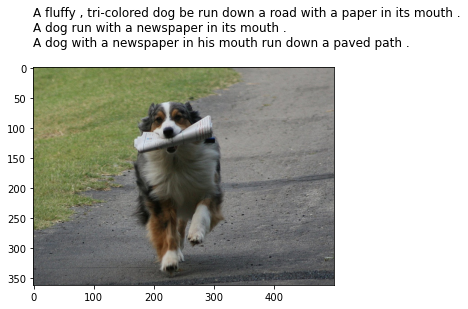

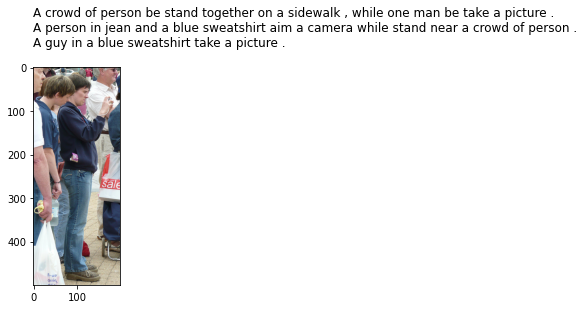

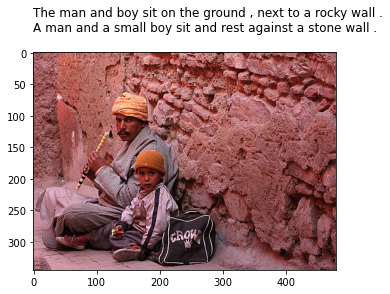

In [4]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# images downloaded from https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing 
# have been stored at Flicker8k_Dataset/
path="Flicker8k_Dataset/"
j=0
for i in df['imageName']:
    text=""
    if(j<3):
        #print(i)
        a=df['caption'].loc[df.imageName==i].to_list()
        for k in range(0,len(a)):
            text=text+a[k]+'\n'
        image=plt.imread(path+i)
        plt.imshow(image)
        plt.title(text,loc='left')
        j=j+1
        plt.show()

### Using Pretrained Resnet-50 model trained on ImageNet dataset for image feature extraction

In [5]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from pickle import dump,load

In [6]:
resnet_model = resnet50.ResNet50(weights='imagenet') # initializing model with imagenet

#### Using resnet model to verify classification of a random image

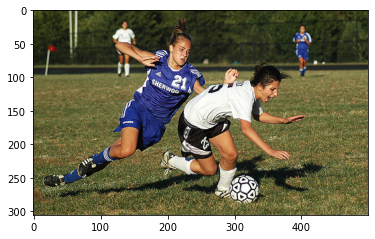

soccer_ball (63.94%)


In [7]:
# load an image from local folder
image = load_img('Flicker8k_Dataset/47871819_db55ac4699.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # prepare the image for the resnet50 model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = resnet_model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
image=plt.imread('Flicker8k_Dataset/47871819_db55ac4699.jpg')
plt.imshow(image)
plt.show()
print('%s (%.2f%%)' % (label[1], label[2]*100))

### Creating a dictionary for all the image ID's and the corresponding caption(s)

In [8]:
img_caps={}
for i in range(0,len(df)-1):
    img=df.imageName.loc[i].split('.')[0]
    caps='startseq ' +df.caption.loc[i]+' endseq'
    img_caps.setdefault(img,[]).append(caps)

#### Splitting the image captions into train_test datasets with 80:20 split ratio

In [9]:
train_size=round(len(img_caps)*80/100)
train_list=list(img_caps.keys())[:train_size]
test_list=list(img_caps.keys())[train_size:]

#### Creating feature vector using resnet model for training images

In [10]:
path="Flicker8k_Dataset/"
features={}
for i in train_list:
    try:
        image = load_img(path+i+'.jpg', target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # prepare the image for the resnet50 model
        image = preprocess_input(image)
        # predict the probability across all output classes
        feature = resnet_model.predict(image)
        image_id=i
        features[image_id]=feature
    except:
        pass

#### Creating a variable to capture all the captions for the image dataset to be used for word corpus using tokenizer

In [11]:
try:
    feat_descr = {k: img_caps[k] for k in train_list}
except:
    pass

In [12]:
all_desc = list()
for key in feat_descr.keys():
    [all_desc.append(d) for d in feat_descr[key]]

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)

In [14]:
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4935


#### Creating training data set and reshaping

In [15]:
X1, X2, y = list(), list(), list()
# walk through each image identifier
for key, desc_list in feat_descr.items():
# walk through each description for the image
    for desc in desc_list:
      # encode the sequence
      seq = tokenizer.texts_to_sequences([desc])[0]
      # split one sequence into multiple X,y pairs
      for i in range(1, len(seq)):
       # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        max_length=max(len(d.split()) for d in all_desc)
       # pad input sequence
       
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
       # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    # store
        X1.append(features[key][0])
        X2.append(in_seq)
        y.append(out_seq)
#return array(X1), array(X2), array(y)

KeyError: '2258277193_586949ec62'

#### Building model using 1 layer of LSTM, L1 regularization, activation functions relu for input layers and softmax for output layer. For compiling the model, we are using categorical_crossentropy loss function and adam optimizer. Dropout added 

In [29]:
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.5)(inputs1)
#adding L1 regularizer to encoder input
fe2 = Dense(256, activation='relu')(fe1)
# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 32, mask_zero=True)(inputs2) 
se2 = Dropout(0.5)(se1)
#Adding one layer of LSTM
se3 = LSTM(256,kernel_regularizer=regularizers.l1(0.0001))(se2)
  # decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model with categorical_crossentropy loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # summarize model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 32)       157920      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_2[0][0]                    
______________________________________________________________________________________________

#### Creating fetures for test dataset

In [30]:
path="Flicker8k_Dataset/"
features_test={}
for i in test_list:
    try:
        image = load_img(path+i+'.jpg', target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # prepare the image for the resnet50 model
        image = preprocess_input(image)
        # predict the probability across all output classes
        feature = resnet_model.predict(image)
        image_id=i
        features_test[image_id]=feature
    except:
        pass

In [31]:
try:
    feat_descr_test = {k: img_caps[k] for k in test_list}
except:
    pass
all_desc_test = list()
for key in feat_descr_test.keys():
    [all_desc_test.append(d) for d in feat_descr_test[key]]
X1_test, X2_test, y_test = list(), list(), list()
# walk through each image identifier
for key, desc_list in feat_descr_test.items():
# walk through each description for the image
    for desc in desc_list:
      # encode the sequence
      seq = tokenizer.texts_to_sequences([desc])[0]
      # split one sequence into multiple X,y pairs
      for i in range(1, len(seq)):
       # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
       # pad input sequence
       
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
       # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    # store
        X1_test.append(features_test[key][0])
        X2_test.append(in_seq)
        y_test.append(out_seq)

#### Adding a checkpoint to save the best performing model with the lowest val_loss

In [32]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#### Training the model using train and test datasets. Calculating overall time taken for model training in minutes

In [33]:
import time
start_time = time.perf_counter()
history=model.fit([np.array(X1), np.array(X2)], np.array(y), epochs=5, verbose=2, callbacks=[checkpoint],
          validation_data=([np.array(X1_test), np.array(X2_test)], np.array(y_test)))
print (round((time.perf_counter() - start_time)/60,3), "minutes taken for model training")

Epoch 1/5
3606/3606 - 802s - loss: 4.5153 - accuracy: 0.2395 - val_loss: 4.0557 - val_accuracy: 0.2894

Epoch 00001: val_loss improved from inf to 4.05566, saving model to model.h5


/Users/fahadaman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
3606/3606 - 679s - loss: 3.8017 - accuracy: 0.3083 - val_loss: 3.7908 - val_accuracy: 0.3190

Epoch 00002: val_loss improved from 4.05566 to 3.79078, saving model to model.h5
Epoch 3/5
3606/3606 - 557s - loss: 3.5321 - accuracy: 0.3314 - val_loss: 3.7024 - val_accuracy: 0.3324

Epoch 00003: val_loss improved from 3.79078 to 3.70243, saving model to model.h5
Epoch 4/5
3606/3606 - 638s - loss: 3.3512 - accuracy: 0.3448 - val_loss: 3.6635 - val_accuracy: 0.3425

Epoch 00004: val_loss improved from 3.70243 to 3.66349, saving model to model.h5
Epoch 5/5
3606/3606 - 814s - loss: 3.2144 - accuracy: 0.3546 - val_loss: 3.6617 - val_accuracy: 0.3482

Epoch 00005: val_loss improved from 3.66349 to 3.66169, saving model to model.h5
58.64 minutes taken for model training


#### Plotting the loss and accuracy history graphs for both train and test set

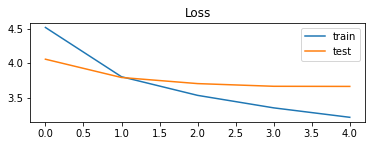

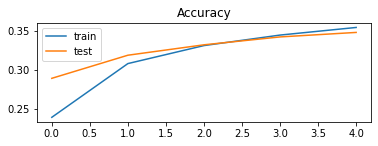

In [34]:
# plot loss for train and test datasets
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# plot accuracy for train and test datasets
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Model evaluation using test dataset

In [35]:
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

In [36]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
     return word
  return None
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length): # seed the generation process
  in_text = 'startseq'
# iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
    # predict next word
    yhat = model.predict([photo,sequence], verbose=0)
    # convert probability to integer
    yhat = argmax(yhat)
    # map integer to word
    word = word_for_id(yhat, tokenizer)
    # stop if we cannot map the word
    if word is None:
      break
    # append as input for generating the next word
    in_text += ' ' + word
# stop if we predict the end of the sequence 
    if word == 'endseq':
      break
  return in_text


def cleanup_summary(summary):
# remove start of sequence token 
  index = str(summary).find('startseq ') 
  if index > -1:
    summary = str(summary)[len('startseq '):] # remove end of sequence token
  index = str(summary).find(' endseq')
  if index > -1:
    summary = str(summary)[:index]
  return summary

In [37]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
    # step over the whole set
  for key, desc_list in descriptions.items():
    # generate description
    yhat = generate_desc(model, tokenizer, photos[key], max_length)
    # clean up prediction
    yhat = cleanup_summary(yhat)
    # store actual and predicted
    references = [cleanup_summary(d).split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
    # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) 
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))) 
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))) 
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [38]:
evaluate_model(model, feat_descr_test, features_test, tokenizer, max_length)

BLEU-1: 0.361183
BLEU-2: 0.195073
BLEU-3: 0.125666
BLEU-4: 0.051635


## Generating caption for a random image downloaded from Google

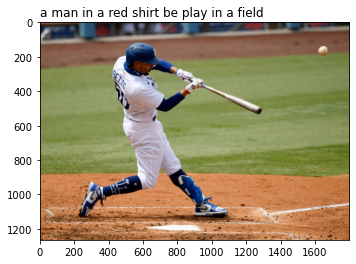

In [45]:
image = load_img('baseball.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # prepare the image for the resnet50 model
image = preprocess_input(image)
# predict the probability across all output classes
photo = resnet_model.predict(image)
description = generate_desc(model, tokenizer, photo, max_length) 
description = cleanup_summary(description)
actual_image=plt.imread('baseball.jpg')
plt.imshow(actual_image)
plt.title(description,loc='left')
plt.show()

## As we can see, the model has predicted a caption for the image shown above and is able to explain the image to some extent.